In [2]:
#Data Understanding and Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ngram_df = pd.read_csv('Preprocessed.csv')

/var/folders/9p/7sb9_6rs4k14xg5ncv4qnqhm0000gn/T/ipykernel_4359/2537213780.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### TTR Analysis


In [13]:
import nltk
from nltk.tokenize import word_tokenize

# Make sure to download the necessary NLTK resource
nltk.download('punkt')

def calculate_ttr(text):
    if pd.isna(text):  # Check if the text is NaN
        return 0  # Return 0 or some predefined TTR value for NaN entries
    
    # Convert text to string in case it's not
    text = str(text).lower()

    # Tokenize the text
    tokens = word_tokenize(text)
    # Calculate number of unique words (types)
    types = len(set(tokens))
    # Calculate total number of words (tokens)
    tokens_count = len(tokens)
    # Calculate Type-Token Ratio (TTR)
    return types / tokens_count if tokens_count > 0 else 0  # Ensure no division by zero

# Load your DataFrame
ttr_df = pd.read_csv('balanced_subset.csv')


# Apply the TTR calculation to the 'cleaned_text' column
ttr_df['TTR'] = ttr_df['cleaned_text'].apply(calculate_ttr)

# Print the first few rows of the DataFrame to see the TTR values
print(ttr_df[['cleaned_text', 'TTR']].head())

# Optionally, save the DataFrame with the TTR column to a new CSV file
ttr_df.to_csv('Updated_with_TTR.csv', index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreasmaskine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                        cleaned_text       TTR
0  thought republican bigger prick toward rep joh...  0.681287
1  johannesburg reuters south africa anc delegate...  0.654244
2  beau biden son vice president joe biden died b...  0.628533
3  criminal brazen crooked group people ever act ...  0.584302
4  thursday donald trump devastated appeal court ...  0.722045


In [15]:
max_ttr_index = ttr_df['TTR'].idxmax()

# Print the row with the highest TTR
print("Row with the highest TTR:")
print(ttr_df.loc[max_ttr_index])

Row with the highest TTR:
label                                                              1
cleaned_text       trump running confirmthere lot change end firs...
cleaned_subject                                             politics
cleaned_title      exclusive america 2021 hilarious poem describe...
token_count                                                       86
TTR                                                         0.896067
Name: 1760, dtype: object


In [16]:
nan_counts = ttr_df.isna().sum()
print("Count of NaN values in each column:")
print(nan_counts)

Count of NaN values in each column:
label              0
cleaned_text       0
cleaned_subject    0
cleaned_title      0
token_count        0
TTR                0
dtype: int64


Lets try to visualize the results 

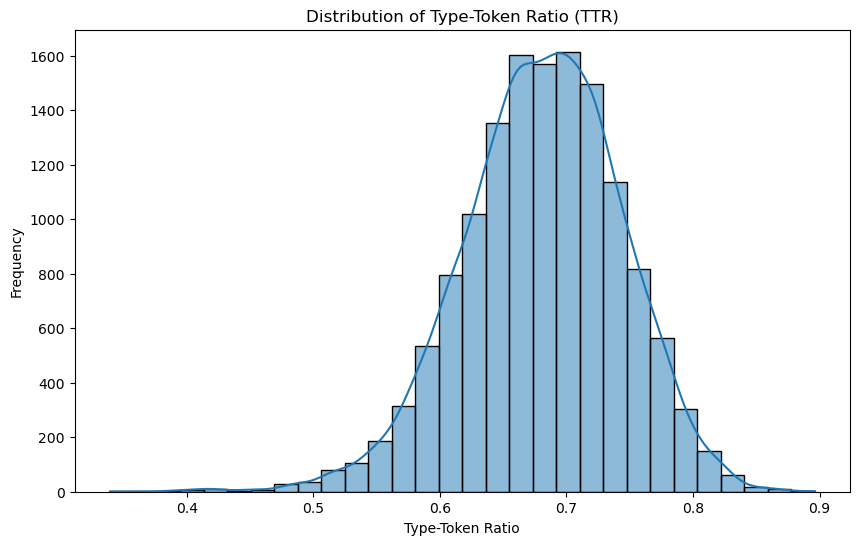

In [17]:
#histogram
import matplotlib.pyplot as plt
import seaborn as sns


# Plot a histogram of the TTR values
plt.figure(figsize=(10, 6))
sns.histplot(ttr_df['TTR'], kde=True, bins=30)  # kde adds a density plot
plt.title('Distribution of Type-Token Ratio (TTR)')
plt.xlabel('Type-Token Ratio')
plt.ylabel('Frequency')
plt.show()

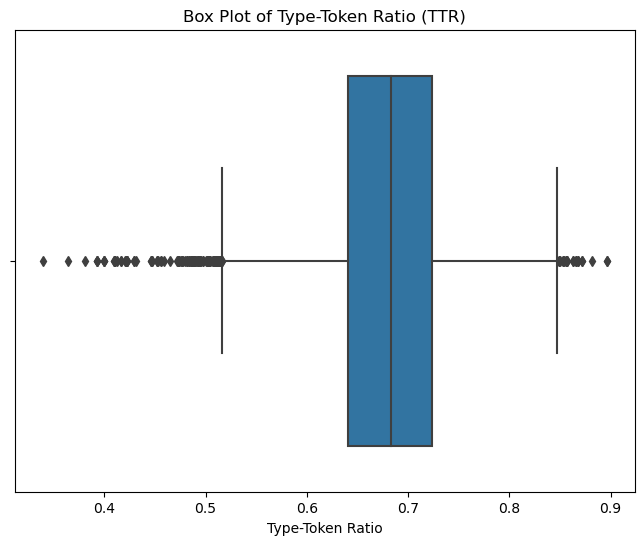

In [18]:
# Box plot

plt.figure(figsize=(8, 6))
sns.boxplot(x=ttr_df['TTR'])
plt.title('Box Plot of Type-Token Ratio (TTR)')
plt.xlabel('Type-Token Ratio')
plt.show()

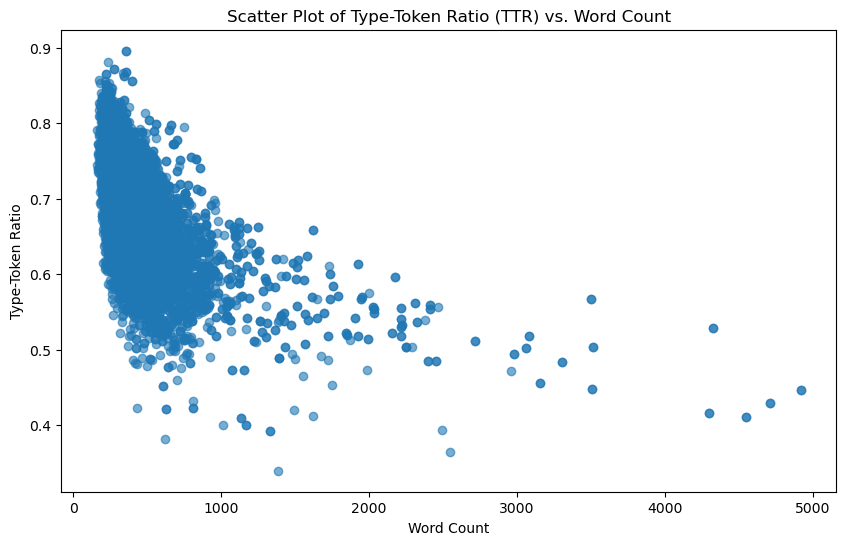

In [19]:
#Scatter Plot

# Example: Plot TTR against another variable 'WordCount'
ttr_df['WordCount'] = ttr_df['cleaned_text'].apply(lambda x: len(x.split()))  # Assuming 'cleaned_text' exists

plt.figure(figsize=(10, 6))
plt.scatter(ttr_df['WordCount'], ttr_df['TTR'], alpha=0.6)
plt.title('Scatter Plot of Type-Token Ratio (TTR) vs. Word Count')
plt.xlabel('Word Count')
plt.ylabel('Type-Token Ratio')
plt.show()

In [20]:
import pandas as pd
import numpy as np
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from gensim.models.ldamodel import LdaModel
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')



# Assume 'cleaned_text' is a column in your DataFrame containing the text data
ttr_df['tokenized_text'] = ttr_df['cleaned_text'].apply(word_tokenize)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(ttr_df['tokenized_text'])
corpus = [dictionary.doc2bow(text) for text in ttr_df['tokenized_text']]

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100,
                     update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Function to calculate a simplified document-level perplexity
def document_perplexity(lda_model, doc_bow):
    # Get topic probability distribution for the document
    doc_topics, word_topics, phi_values = lda_model.get_document_topics(doc_bow, per_word_topics=True)
    # Compute perplexity for the document (simplified version)
    doc_perplexity = np.exp(-np.mean([score for _, score in doc_topics]))
    return doc_perplexity

# Calculate document-level perplexity for each document in the corpus
ttr_df['doc_perplexity'] = [document_perplexity(lda_model, corp) for corp in corpus]

# Save the updated DataFrame with the new 'doc_perplexity' feature
ttr_df.to_csv('Updated_with_Doc_Perplexity.csv', index=False)

# Print some of the updated DataFrame rows to check
print(ttr_df[['cleaned_text', 'doc_perplexity']].head())


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreasmaskine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                        cleaned_text  doc_perplexity
0  thought republican bigger prick toward rep joh...        0.849205
1  johannesburg reuters south africa anc delegate...        0.821550
2  beau biden son vice president joe biden died b...        0.894878
3  criminal brazen crooked group people ever act ...        0.780792
4  thursday donald trump devastated appeal court ...        0.867595


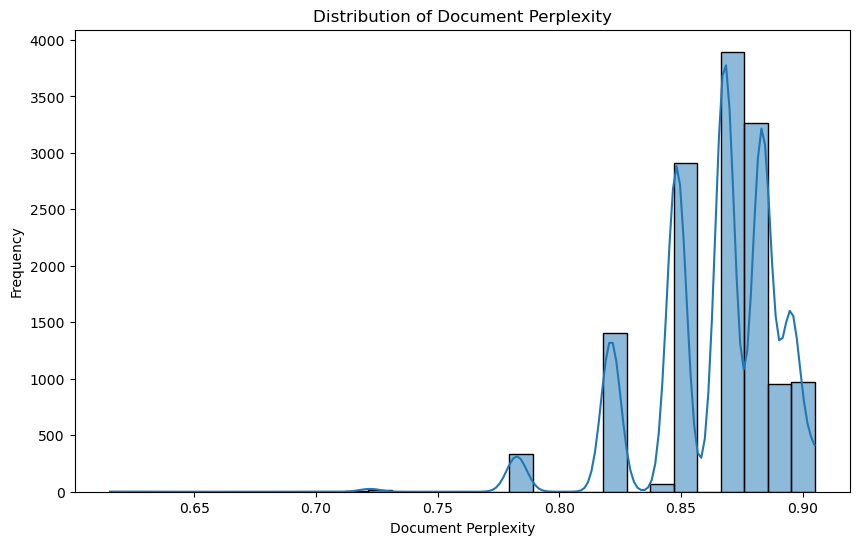

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns



# Plot a histogram of the document perplexity
plt.figure(figsize=(10, 6))
sns.histplot(ttr_df['doc_perplexity'], kde=True, bins=30)
plt.title('Distribution of Document Perplexity')
plt.xlabel('Document Perplexity')
plt.ylabel('Frequency')
plt.show()


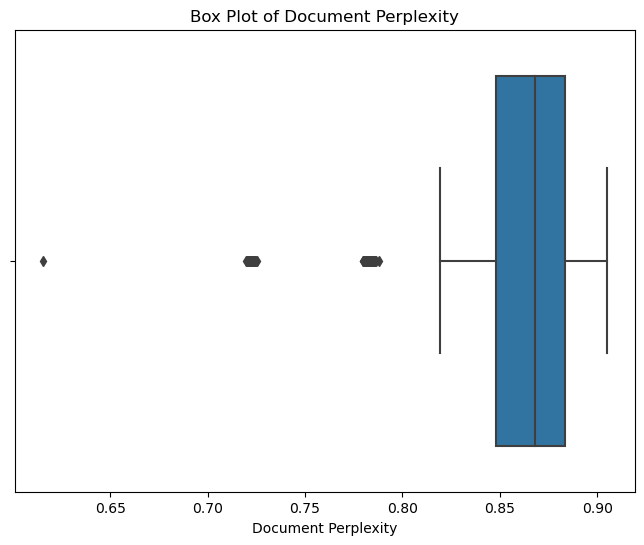

In [22]:
# Plot a box plot of document perplexity
plt.figure(figsize=(8, 6))
sns.boxplot(x=ttr_df['doc_perplexity'])
plt.title('Box Plot of Document Perplexity')
plt.xlabel('Document Perplexity')
plt.show()

/var/folders/yf/k_3x664j2td3m_608947vjl00000gn/T/ipykernel_46801/1638482124.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ttr_df['doc_perplexity'], shade=True)


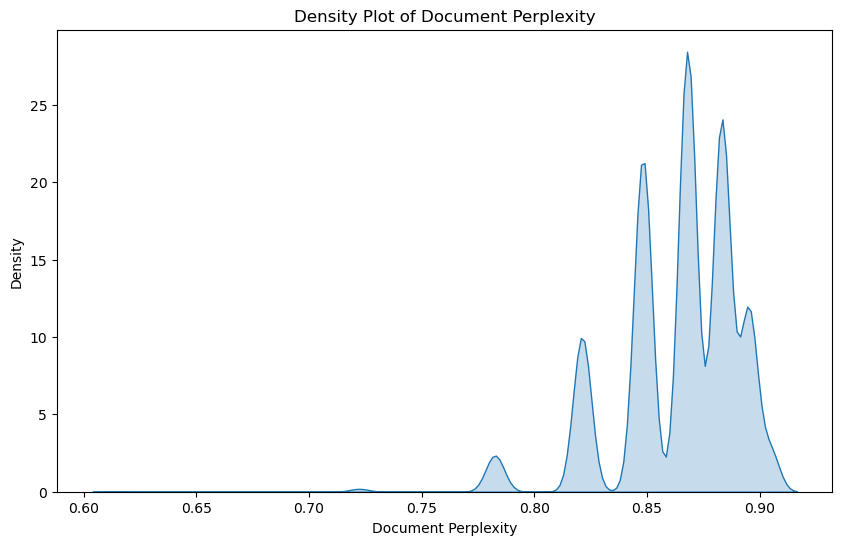

In [23]:
# Plot a density plot of document perplexity
plt.figure(figsize=(10, 6))
sns.kdeplot(ttr_df['doc_perplexity'], shade=True)
plt.title('Density Plot of Document Perplexity')
plt.xlabel('Document Perplexity')
plt.ylabel('Density')
plt.show()


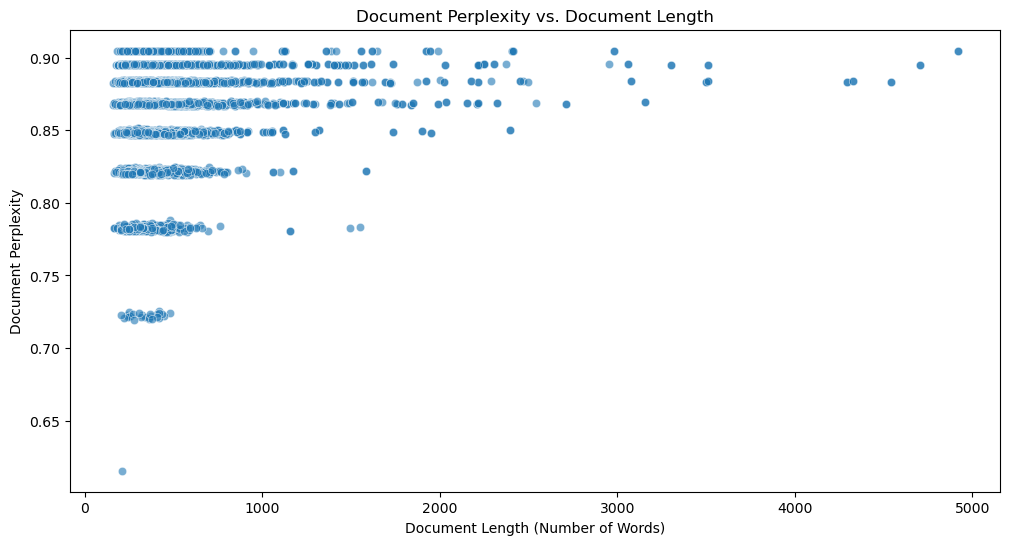

In [26]:
# Assuming 'cleaned_text' contains the textual data
ttr_df['document_length'] = ttr_df['cleaned_text'].apply(lambda x: len(x.split()))

# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(x='document_length', y='doc_perplexity', data=ttr_df, alpha=0.6)
plt.title('Document Perplexity vs. Document Length')
plt.xlabel('Document Length (Number of Words)')
plt.ylabel('Document Perplexity')
plt.show()